# BootComp Experimental Developments

This notebook is used for development of BootComp procedures

In [75]:
import Bootstrap as bs
import BootIO as io
import BootChartExtensions as ch
import MCC as mcc
import ConvFuncs as cf

In [76]:
#DEV
import Bootstrap_crn as crn

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Parameters and setup

In [78]:
N_BOOTS = 2000
INPUT_DATA = "data/real_scenarios.csv"

In [79]:
scenario_data = crn.load_scenarios(INPUT_DATA)
N_SCENARIOS = scenario_data.shape[1]
print("Loaded data. {0} scenarios".format(N_SCENARIOS))

Loaded data. 59 scenarios


In [80]:
scenario_data.shape

(20, 59)

In [81]:
args =  bs.BootstrapArguments()

args.nboots = N_BOOTS
args.nscenarios = N_SCENARIOS

args.point_estimate_func = bs.bootstrap_mean
args.difference_func = bs.boot_mean_diff
args.summary_func = bs.proportion_x2_lessthan_x1

## 2. Analysis Procedures

### 2.1 Resampling

In [82]:
boot_data = crn.resample_all_scenarios(scenario_data, N_BOOTS)

In [83]:
boot_data.shape

(2000, 59)

In [84]:
df_boots = pd.DataFrame(boot_data, columns = [i+1 for i in range(N_SCENARIOS)])


In [85]:
df_boots.index = df_boots.index+1

In [86]:
df_boots

,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
1,0.781893,3.148353,2.036351,1.392387,0.897805,0.851852,0.852538,0.781207,0.781893,0.781893,...,0.312346,0.173525,0.058985,0.058985,0.058298,3.502607,0.306584,0.095336,0.061043,0.061043
2,0.895473,3.108436,1.830453,1.619616,1.134157,1.031276,1.006585,0.897531,0.895473,0.895473,...,0.393553,0.251029,0.102881,0.101509,0.100822,5.599589,0.417696,0.118656,0.101509,0.100823
3,1.479013,4.063718,2.907134,2.213306,1.822634,1.703978,1.614129,1.480384,1.479013,1.479013,...,0.665844,0.326475,0.187243,0.181756,0.179698,8.564746,0.639232,0.197531,0.181756,0.179698
4,1.267490,3.449794,2.546502,1.929561,1.491770,1.446502,1.328533,1.267490,1.267490,1.267490,...,0.591770,0.253086,0.165295,0.165295,0.162550,10.405213,0.551440,0.204390,0.164609,0.162551
5,1.014815,3.247668,2.294719,1.576955,1.156790,1.132785,1.064884,1.014129,1.014815,1.014815,...,0.377229,0.175583,0.100823,0.099451,0.098764,7.632099,0.385460,0.135117,0.100823,0.100137
6,0.827161,2.890466,1.920233,1.352058,0.982853,0.954733,0.880659,0.827161,0.827161,0.827161,...,0.366667,0.240741,0.102195,0.102195,0.100136,5.749040,0.341564,0.145405,0.102195,0.101509
7,1.485048,3.818587,3.013787,1.969067,1.649657,1.609191,1.524143,1.482305,1.485048,1.485048,...,0.596708,0.181756,0.157750,0.155007,0.152263,8.888409,0.628944,0.174211,0.154321,0.152263
8,1.131688,3.642935,2.531276,1.755007,1.320988,1.283951,1.180384,1.131002,1.131688,1.131688,...,0.437449,0.237311,0.109054,0.109054,0.106308,5.555899,0.497257,0.138546,0.109739,0.109054
9,1.153361,3.493141,2.480659,1.878738,1.394102,1.316598,1.213718,1.153361,1.153361,1.153361,...,0.494376,0.214678,0.123457,0.122085,0.120026,6.867764,0.540467,0.146091,0.124143,0.122771
10,1.050892,3.111179,2.390398,1.564884,1.210014,1.159259,1.116050,1.050206,1.050892,1.050892,...,0.401921,0.222908,0.113169,0.110425,0.109053,6.454938,0.393690,0.124829,0.111111,0.110425


### 2.2. Comparison Scenarios

In [87]:
# cast from numpy array to list of lists for backward compatability
boot_data2 = boot_data.T.tolist()


In [88]:
results = bs.compare_scenarios_pairwise(boot_data2, args) 

### 2.3. Printing Results

In [89]:
matrix = io.results_to_matrix(results)
io.insert_inverse_results(matrix, args.nscenarios)
df = cf.matrix_to_dataframe(matrix, io.scenario_headers(args.nscenarios))
df.style.applymap(io.colour_cells_by_proportion)

## 2.4 Ranking Systems

### 2.4.1 Rank by wins

In [90]:
ranks = bs.rank_systems_max(df_boots, args)
s_ranks = ranks.sort_values("f_x", ascending=False)
s_ranks

,f_x,p_x
system,,
20,1792,0.8960
55,111,0.0555
13,76,0.0380
25,21,0.0105


### 2.4.2 Top m

In [97]:
msmallest = bs.rank_systems_msmallest(df_boots, args, 3)
msmallest

,f_x,p_x
system,,
29,1270,0.6350
38,882,0.4410
48,781,0.3905
59,718,0.3590
54,690,0.3450
36,565,0.2825
47,427,0.2135
35,244,0.1220
39,206,0.1030


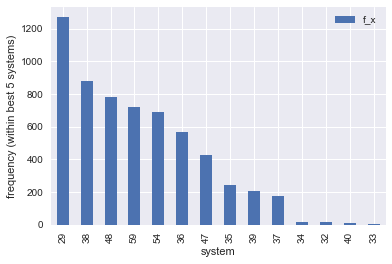

In [98]:
s_ranks = msmallest.sort_values("f_x", ascending=False)
ax= s_ranks.plot(x=s_ranks.index, y='f_x', kind='bar')
ax.set_ylabel('frequency (within best 5 systems)')

plt.show()

### Rerunning the comparisons with smaller subset

In [99]:
subset_indexes = msmallest.index.values.tolist()
#zero indexed
subset_indexes_zero = [x - 1 for x in subset_indexes]

subset = cf.subset_of_list(boot_data, subset_indexes_zero)


In [100]:
args.nscenarios = len(subset)
args.summary_func = bs.proportion_x2_lessthan_x1
#args.summary_func = bs.proportion_x2_greaterthan_x1
results = bs.compare_scenarios_pairwise(subset, args) 
matrix = io.results_to_matrix(results) 
io.insert_inverse_results(matrix, args.nscenarios)

In [101]:
df_subset = cf.matrix_to_dataframe(matrix, [str(i) for i in subset_indexes])
df_subset.style.applymap(io.colour_cells_by_proportion)

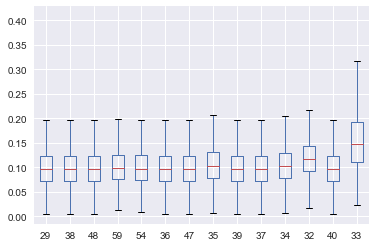

In [102]:
subset_indexes = msmallest.index.values.tolist()
ax = df_boots[subset_indexes].plot.box()